In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Let's load the parquetfile we saved in notebook 1. You will need to change the filename!

In [3]:
processed = Path("../data/processed")
datafile = processed / "whatsapp-20240214-112323.parq"
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")

Note how datatypes have been preserved.

In [4]:
df = pd.read_parquet(datafile)
df.dtypes

timestamp    datetime64[ns]
author               object
message              object
has_emoji              bool
dtype: object

In [5]:
df.head()

,timestamp,author,message,has_emoji
0,2017-03-05 15:08:00,Unknown,05-03-2017 15:08 - ‎Bryan Zaagsma heeft de gro...,True
1,2018-05-07 08:09:00,Unknown,07-05-2018 08:09 - ‎Bryan Zaagsma heeft u toeg...,False
2,2018-05-07 08:13:00,Justin Velthuijsen,2\n,False
3,2018-05-07 08:14:00,Kerim Ozel,3\n,False
4,2018-05-07 08:20:00,Stephan van den Hoogen,4\n,False


Let's count the amount of messages, per author.

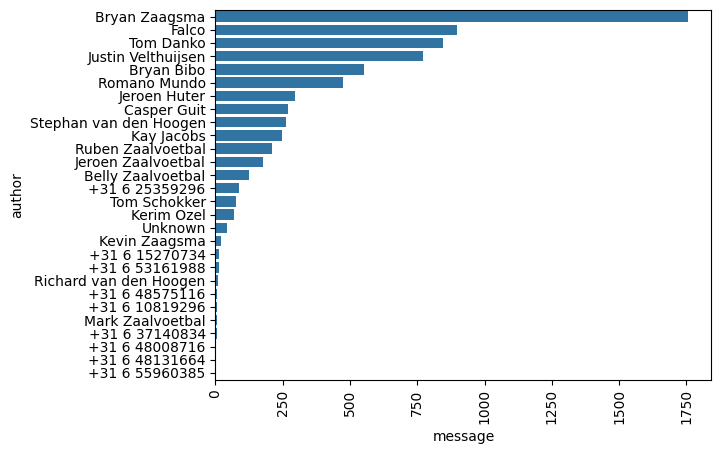

In [6]:
p1 = df[['author', 'message']].\
    groupby("author").\
    count().\
    sort_values("message", ascending=False)
sns.barplot(y=p1.index, x="message", data=p1)
plt.xticks(rotation=90);

Maybe tweak the colors a bit

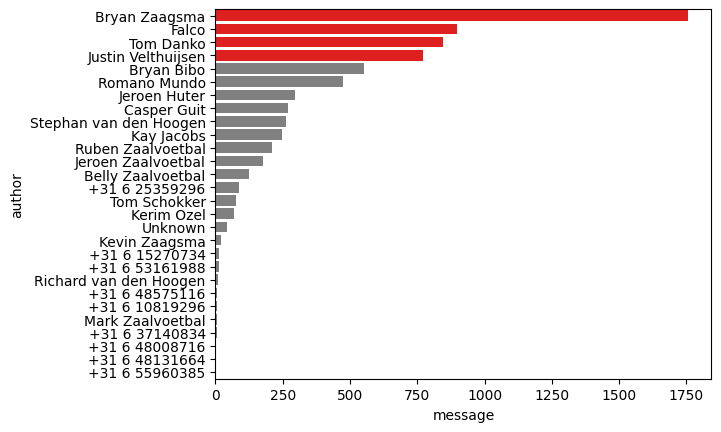

In [8]:
colors = [0 if x < 700 else 1 for x in p1.message]
custom_palette = {0: "grey", 1: "red"}
sns.barplot(y=p1.index, x="message", hue=colors, data=p1, palette=custom_palette, legend=False);

Let's calculate the average message length.

Text(0.5, 0, 'Average message length')

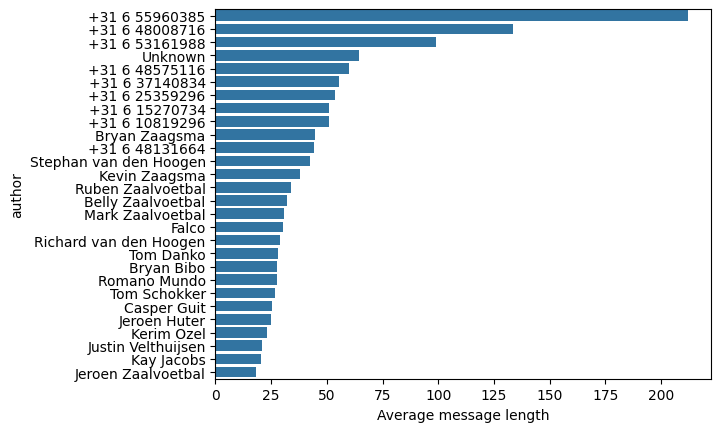

In [9]:
df['message_length'] = df['message'].str.len()
p1 = df[['author', 'message_length']].\
    groupby("author").\
    mean().\
    sort_values("message_length", ascending=False)
sns.barplot(y=p1.index, x="message_length", data=p1)
plt.xlabel("Average message length")

Create a simple regex to look for links in the messages and add that as a feature:

<Axes: xlabel='has_link', ylabel='author'>

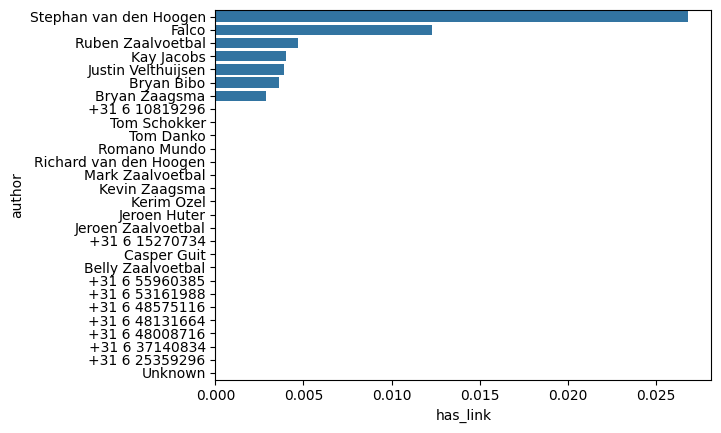

In [10]:
has_link = r"http"
df['has_link'] = df['message'].str.contains(has_link)
p1 = df[['author', 'has_link']].\
    groupby("author").\
    mean().\
    sort_values("has_link", ascending=False)
sns.barplot(y=p1.index, x="has_link", data=p1)

Aggregate the emojis per user (can you change between sum and mean?)

<Axes: xlabel='sum', ylabel='author'>

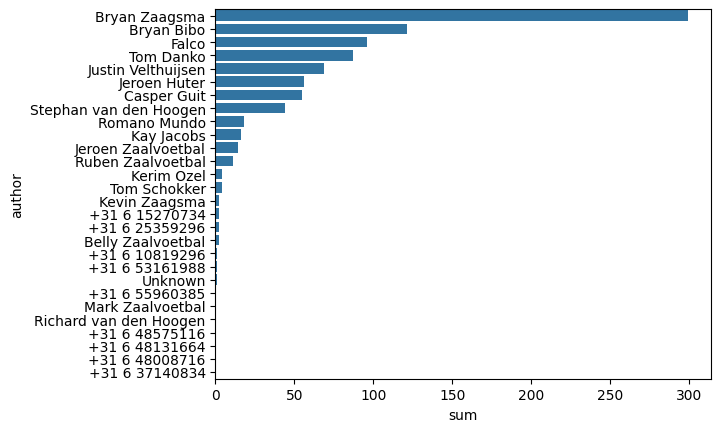

In [11]:
p2 = df[['author', 'has_emoji']].\
    groupby('author').\
    agg(['sum', 'mean']).\
    sort_values(('has_emoji', 'sum'), ascending=False)
p2.columns = p2.columns.droplevel(0)
sns.barplot(y=p2.index, x="sum", data=p2)

Let's add a cateory, based on the time when authors send a message:

In [15]:
import pandas as pd
# Define the time ranges
time_ranges = ['00:00', '08:00', '17:30', '22:00', '23:59']
# Define the category labels
categories = ['early morning', 'worktimes', 'evening', 'late']
# Categorize the timestamp column
df['timestamp_category'] = pd.cut(df['timestamp'].dt.time.astype(str), bins=time_ranges, labels=categories, right=False)
# Display the updated dataframe
df

ValueError: could not convert string to float: '00:00'

Now we can group and count the categories:

In [16]:
# Group the dataframe by 'author' and 'timestamp_category', and count the occurrences
p3 = df.groupby(['author', 'timestamp_category']).size().unstack()

# Calculate the fraction of each category for every author
p3_frac = p3.div(p3.sum(axis=1), axis=0)
p3_frac

KeyError: 'timestamp_category'

Let's use plotly the create a stacked bar chart:

In [ ]:
import plotly.express as px
p4 = p3_frac.reset_index().melt(id_vars='author')
fig = px.bar(p4, y="author", x="value", color="timestamp_category", barmode="stack")
fig.show()

Let's extract the minimum and maximum time of the messages for every author, and convert that to a decimal fraction:

In [17]:
df['hour'] = df['timestamp'].dt.time
summary_df = df.groupby('author')['hour'].agg(['min', 'max']).reset_index()

def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour

summary_df['min_x_values'] = summary_df['min'].apply(convert_to_decimal_hours)
summary_df['max_x_values'] = summary_df['max'].apply(convert_to_decimal_hours)

# Drop the original 'min' and 'max' columns as they are no longer needed
summary_df = summary_df.drop(['min', 'max'], axis=1)
summary_df.head()

,author,min_x_values,max_x_values
0,+31 6 10819296,9.216667,19.250000
1,+31 6 15270734,10.450000,18.133333
2,+31 6 25359296,8.716667,22.350000
3,+31 6 37140834,9.900000,19.883333
4,+31 6 48008716,10.833333,23.216667


With this, we can create a nice barbell chart. Try to add colors for your own chart!

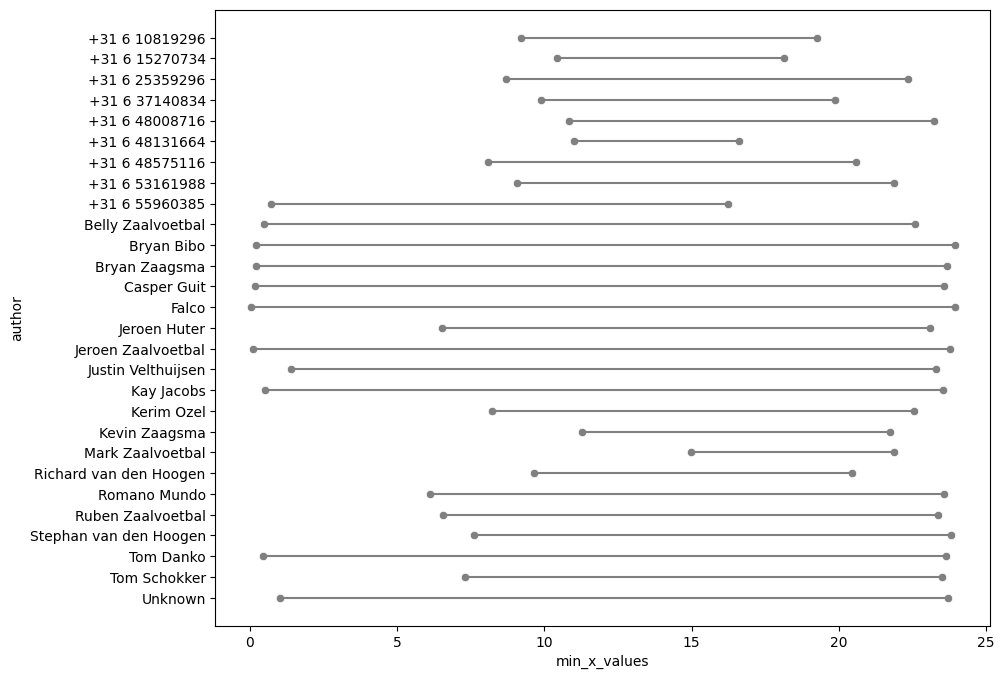

In [18]:
# Create a larger plot
plt.figure(figsize=(10, 8))

# Create scatter plots
sns.scatterplot(data=summary_df, x='min_x_values', y='author', color='grey')
sns.scatterplot(data=summary_df, x='max_x_values', y='author', color='grey')

# Add lines
for index, row in summary_df.iterrows():
    plt.plot([row['min_x_values'], row['max_x_values']], [row['author'], row['author']], color='grey')


# Adjust the font size of the y-axis labels if needed
plt.yticks(fontsize=10)

# Show the plot
plt.show()

Another approach for comparing is to create a heatmap:

<Axes: xlabel='day_of_week', ylabel='author'>

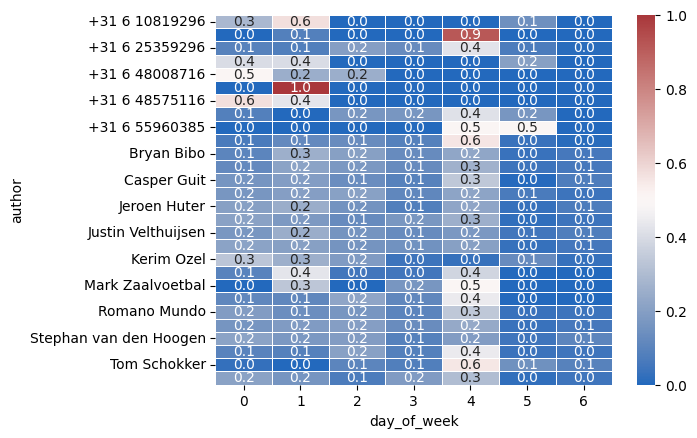

In [19]:
df['day_of_week'] = df['timestamp'].dt.dayofweek
author_day_counts = df.groupby(['author', 'day_of_week']).size().unstack(fill_value=0)
author_day_percentages = author_day_counts.div(author_day_counts.sum(axis=1), axis=0)
sns.heatmap(author_day_percentages, annot=True, fmt=".1f", linewidths=.5, cmap="vlag")

Let's save all the new features we added:

In [20]:
df.to_parquet(datafile, index=False)